In [1]:
import csv
import numpy as np
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import pickle
import pandas as pd
#import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir='../data/Current Data/'

In [3]:
CategoricalFeatures=[]
NumericFeatures=[]

demographics

In [4]:
df_demographics=pd.read_csv(data_dir+'REACT_Demographics'+'.csv')
#df_demographics.info()

In [5]:
#df_demographics.head()

In [6]:
#df_demographics.columns

In [7]:
CategoricalFeatures+=['GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']
NumericFeatures+=['PATIENT_AGE']

In [8]:
studyid_data_dic=dict()
for studyid,age,gender,ethnic,smoking in df_demographics[['STUDY_ID','PATIENT_AGE','GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']].values:
    if age is not np.nan and gender is not np.nan and ethnic is not np.nan and smoking is not np.nan:
        if studyid not in studyid_data_dic:
            studyid_data_dic[studyid]=dict()
        studyid_data_dic[studyid]['PATIENT_AGE']=age
        studyid_data_dic[studyid]['GENDER']=str(gender)
        studyid_data_dic[studyid]['ETHNIC_GROUP']=ethnic
        studyid_data_dic[studyid]['SMOKING_HISTORY']=smoking
#studyid_data_dic

Comorbidities

In [9]:
df_comorbidities=pd.read_csv(data_dir+'REACT_Comorbidities_unpivoted'+'.csv')
#df_demographics.info()

In [10]:
comorbidities=list(df_comorbidities.COMORBIDITY.unique())
NumericFeatures+=comorbidities
for studyid in studyid_data_dic:
    for co in comorbidities:
        studyid_data_dic[studyid][co]=0

In [11]:
for studyid,co,status in df_comorbidities.values:
    if studyid in studyid_data_dic:
        studyid_data_dic[studyid][co]=status
#studyid_data_dic

label: NIV Days number

In [12]:
df_Vitalsigns_Categorical=pd.read_csv(data_dir+'REACT_Vitalsigns_Categorical'+'.csv')
#df_Vitalsigns_Categorical.info()

In [13]:
#df_Vitalsigns_Categorical.head()

In [14]:
CategorySet=dict()
CategorySet[0]=set(['Air - Not Supported'])
CategorySet[1]=set([
    'Nasal Specs', 'Face Mask', 'Venturi Mask',
    'Non-Rebreath Mask', 'Optiflow / Hi Flow',
    'Trachy Mask'
])
CategorySet[2]=set([
    'NIV - CPAP face mask', 'NIV - CPAP full face mask',
    'NIV - BIPAP face mask', 'NIV - CPAP nasal mask',
    'NIV - BIPAP nasal mask', 'NIV - BIPAP full face mask'
])
CategorySet[3]=set(['Invasive Ventilation'])
CategoryDictionary=dict([(item,label) for label in CategorySet for item in CategorySet[label]])
CategoryDictionary

{'Air - Not Supported': 0,
 'Optiflow / Hi Flow': 1,
 'Trachy Mask': 1,
 'Non-Rebreath Mask': 1,
 'Nasal Specs': 1,
 'Face Mask': 1,
 'Venturi Mask': 1,
 'NIV - BIPAP face mask': 2,
 'NIV - BIPAP nasal mask': 2,
 'NIV - CPAP face mask': 2,
 'NIV - CPAP nasal mask': 2,
 'NIV - CPAP full face mask': 2,
 'NIV - BIPAP full face mask': 2,
 'Invasive Ventilation': 3}

In [15]:
df_label=df_Vitalsigns_Categorical[
    (df_Vitalsigns_Categorical.PARAMETER=='Respiratory Support') &\
    (df_Vitalsigns_Categorical.VALUE.map(lambda x:False if x not in CategoryDictionary else CategoryDictionary[x])>=3)
][['STUDY_ID','UNITFROM_DATETIME','UNITTO_DATETIME']]

In [16]:
max_end_datetime=max([x for x in list(df_Vitalsigns_Categorical.UNITTO_DATETIME.unique()) if x is not np.nan])
max_end_datetime

'2020-06-12 15:45:33.137'

In [17]:
from datetime import datetime

label_studyid_time_dic=dict()
for study_id,start_datetime,end_datetime in df_label.values:
    start_datetime=datetime.strptime(start_datetime.split('.')[0],'%Y-%m-%d %H:%M:%S')
    end_datetime=datetime.strptime(end_datetime.split('.')[0] if end_datetime is not np.nan else max_end_datetime.split('.')[0],'%Y-%m-%d %H:%M:%S')
    if study_id not in label_studyid_time_dic:
        label_studyid_time_dic[study_id]=[None,None]
    if label_studyid_time_dic[study_id][0] is None or label_studyid_time_dic[study_id][0]>start_datetime:
        label_studyid_time_dic[study_id][0]=start_datetime
    if label_studyid_time_dic[study_id][1] is None or label_studyid_time_dic[study_id][0]<end_datetime:
        label_studyid_time_dic[study_id][1]=end_datetime

#label_studyid_time_dic

In [18]:
for studyid in studyid_data_dic:
    if studyid not in label_studyid_time_dic:
        studyid_data_dic[studyid]['TIME_POINT']=None
        studyid_data_dic[studyid]['PREDICTION_LABEL']=0
    else:
        start_datetime,end_datetime=label_studyid_time_dic[studyid]
        studyid_data_dic[studyid]['TIME_POINT']=start_datetime
        studyid_data_dic[studyid]['PREDICTION_LABEL']=(end_datetime-start_datetime).days
#studyid_data_dic

labresults

In [19]:
df_labresults=pd.read_csv(data_dir+'REACT_LabResults'+'.csv')
#df_labresults.info()

In [20]:
#df_labresults.head()

In [21]:
testcode_lst=list(df_labresults.REACT_TESTCODE.unique())
testcode2id=dict([(testcode_lst[i],i) for i in range(len(testcode_lst))])

In [22]:
from datetime import datetime

studyid_testcode_time_numeric_dic=dict()
for studyid,test_time,testcode,numeric,lower,upper in df_labresults[[
    'STUDY_ID','PATHOLOGY_SPECIMEN_DATE','REACT_TESTCODE',
    'PATHOLOGY_RESULT_NUMERIC','LOWER_RANGE','UPPER_RANGE']].values:
    test_time=datetime.strptime(test_time,'%Y-%m-%d %H:%M:%S')
    if studyid not in studyid_testcode_time_numeric_dic:
        studyid_testcode_time_numeric_dic[studyid]=[]
    studyid_testcode_time_numeric_dic[studyid].append([test_time,testcode,numeric])
#studyid_testcode_time_numeric_dic

In [23]:
NumericFeatures+=[testcode+suffix for testcode in testcode_lst for suffix in ['_MIN','_MAX','_MEAN']]

In [24]:
for studyid in studyid_data_dic:
    for testcode in testcode_lst:
        for suffix in ['_MIN','_MAX','_MEAN']:
            studyid_data_dic[studyid][testcode+suffix]=None
    time_point=studyid_data_dic[studyid]['TIME_POINT']
    if studyid in studyid_testcode_time_numeric_dic:
        individual_labresult_dic=dict()
        for test_time,testcode,numeric in studyid_testcode_time_numeric_dic[studyid]:
            if time_point is None or test_time<time_point:
                if testcode not in individual_labresult_dic:
                    individual_labresult_dic[testcode]=[]
                individual_labresult_dic[testcode].append(numeric)
        for testcode in individual_labresult_dic:
            studyid_data_dic[studyid][testcode+'_MIN']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MAX']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MEAN']=np.mean(individual_labresult_dic[testcode])

data preprocessing

In [25]:
studyid_lst=list(studyid_data_dic.keys())
#studyid_lst

In [26]:
X_cols=[]

In [27]:
from sklearn.preprocessing import OneHotEncoder

X_categorical=[[studyid_data_dic[studyid][k] for k in CategoricalFeatures] for studyid in studyid_lst]

enc = OneHotEncoder(handle_unknown='ignore')
X_onehot=enc.fit_transform(X_categorical).toarray()

X_cols+=list(enc.get_feature_names(CategoricalFeatures))

In [28]:
X_numeric=[[studyid_data_dic[studyid][k] for k in NumericFeatures] for studyid in studyid_lst]
X_cols+=NumericFeatures

In [29]:
X_missing_value=np.concatenate((X_onehot,X_numeric), axis=1)

In [30]:
Y=np.array([studyid_data_dic[studyid]['PREDICTION_LABEL'] for studyid in studyid_lst])

balance_ratio=len([_ for v in Y if v==0])/len([_ for v in Y if v==1])
balance_ratio

from functools import reduce

XY_missing_value_balanced=np.array(
    reduce(lambda a,b:a+b,[[list(x)+[y]]*(int(balance_ratio) if y==1 else 1) for x,y in zip(X_missing_value,Y)])
)

X_missing_value=XY_missing_value_balanced[:,:-1]
Y=np.array(XY_missing_value_balanced[:,-1],dtype=int)

fill in nan

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X=imputer.fit_transform(X_missing_value[:,:-1])

Prediction Classification task (RespiratorySupportRequired:1 or not:0)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

models={
    "Linear":LinearRegression(),
    "MLP":MLPRegressor(max_iter=3000,solver='adam', alpha=1e-3,hidden_layer_sizes=(64)),
    "DecisionTree":DecisionTreeRegressor(),
    "RandomForest":RandomForestRegressor(),
    "AdaBoost":AdaBoostRegressor(n_estimators=100),
    "GradientBoosting":GradientBoostingRegressor(),
    "XGBoost":XGBRegressor(n_estimators=100)
}

In [33]:
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score,mean_squared_error

ap_result_lst=[]

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    ap_result_lst.append(
        [r2_score(y_test,models[model_name].fit(X_train,y_train).predict(X_test))\
                for model_name in models])

print(pd.DataFrame(ap_result_lst,columns=[model_name for model_name in models]))

         Linear       MLP  DecisionTree  RandomForest  AdaBoost  \
0  1.749810e-02 -0.744929     -4.402485     -0.234032 -0.021030   
1  4.830777e-02 -1.271698     -1.091074     -0.383096 -2.249139   
2 -1.550730e-01 -3.460964     -0.803115     -0.486928 -8.407730   
3  1.923701e-01 -2.223730     -0.675922      0.350329 -5.061120   
4  6.784276e-03 -7.620613      0.399569      0.375515 -7.407818   
5 -1.061706e+00 -0.294864     -1.221676     -0.102011 -1.819261   
6 -2.674455e-02 -7.687273     -0.795896     -0.069937 -0.093670   
7 -2.126094e-01 -8.901763     -0.210380     -0.057991 -1.785232   
8 -1.332801e+17 -7.146890     -1.622447     -0.324127 -2.713639   
9 -1.722255e-02 -0.209339     -1.909734     -0.046501 -5.654406   

   GradientBoosting   XGBoost  
0         -0.171209 -0.371914  
1          0.024255 -0.254246  
2         -0.223638 -1.118455  
3          0.351530  0.108060  
4          0.312966 -0.062684  
5         -0.162449 -0.412638  
6         -0.011924 -0.185993  
7     

In [34]:
print(pd.DataFrame(np.mean(ap_result_lst,axis=0,keepdims=True),columns=[model_name for model_name in models]))

         Linear       MLP  DecisionTree  RandomForest  AdaBoost  \
0 -1.332801e+16 -3.956206     -1.233316     -0.097878 -3.521304   

   GradientBoosting   XGBoost  
0         -0.037069 -0.434674  


In [35]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression().fit(X, Y)

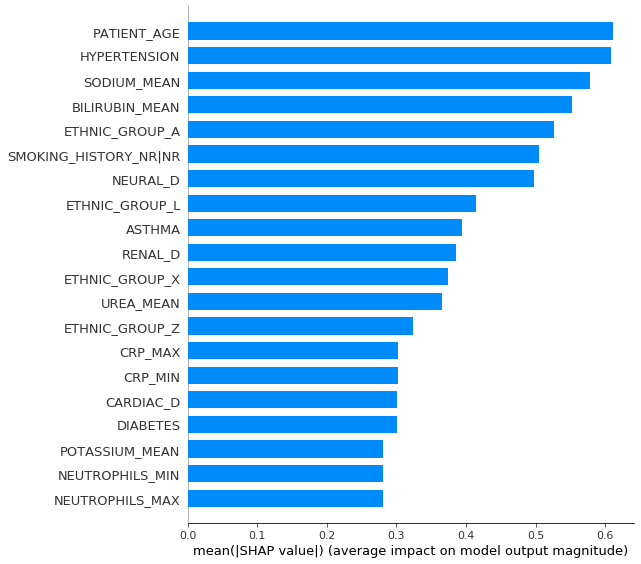

In [36]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.LinearExplainer(regr,X)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar")

In [37]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor().fit(X, Y)

In [38]:
feature_importance_dic=dict(zip(X_cols,regr.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(regr, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.20988479958855538
UREA_MEAN : 0.10136755156345827
HIV : 0.059352159008834206
ETHNIC_GROUP_L : 0.05201592824375834
HYPERTENSION : 0.03814290435129926
ETHNIC_GROUP_N : 0.03457052279652187
GENDER_2 : 0.028221992350981696
NEURAL_D : 0.02776783263150067
ETHNIC_GROUP_A : 0.024935234728073748
SMOKING_HISTORY_NR|NR : 0.022671688097939645
CRP_MIN : 0.020556714175320276
GENDER_1 : 0.020539396396887368
CRP_MAX : 0.019010483942482514
GLUCOSE_MAX : 0.01873035860953653
SMOKING_HISTORY_Never smoked|NR : 0.01822809847938583
UREA_MAX : 0.017734734859250666
COPD : 0.017668190819975324
UREA_MIN : 0.017545919194970623
LIVER_D : 0.017022689818673095
BILIRUBIN_MIN : 0.013858216588828092


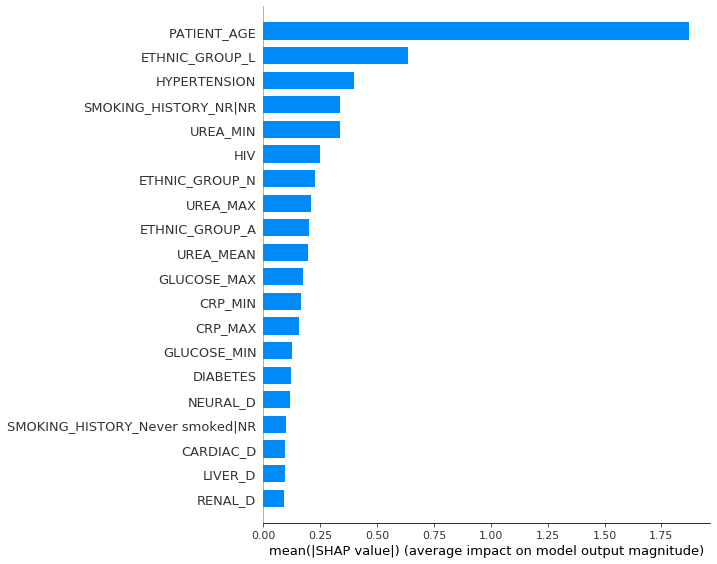

In [39]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar")

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor().fit(X, Y)

In [41]:
feature_importance_dic=dict(zip(X_cols,regr.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(regr, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

UREA_MEAN : 0.23734319026719453
PATIENT_AGE : 0.17447940847913984
ETHNIC_GROUP_L : 0.08374443295109023
HIV : 0.0694065784806292
WBC_MEAN : 0.055399843218207366
GLUCOSE_MAX : 0.03828103953309987
COPD : 0.03653921595419463
CRP_MIN : 0.030732578828244893
ETHNIC_GROUP_A : 0.030541695878885847
ETHNIC_GROUP_N : 0.030273386233697956
GENDER_1 : 0.024172375657347374
GENDER_2 : 0.019113054888935395
CRP_MAX : 0.014662432369648676
CREATENINE_MIN : 0.010735553025873396


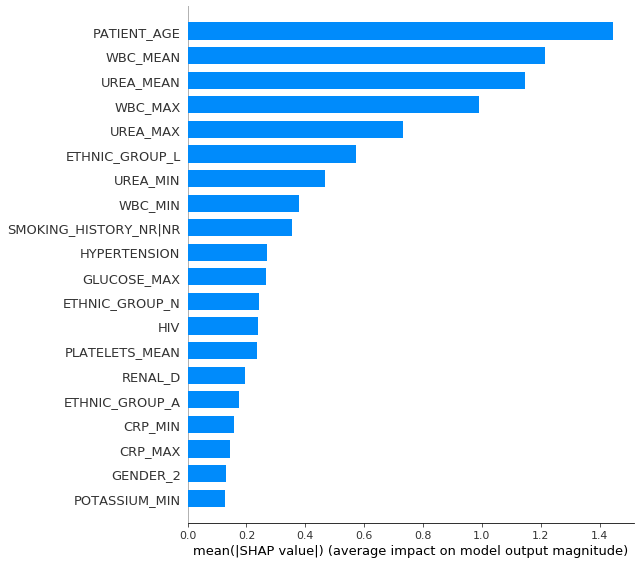

In [42]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar")

In [43]:
from xgboost import XGBRegressor

regr=XGBRegressor(n_estimators=100).fit(X,Y)

In [44]:
feature_importance_dic=dict(zip(X_cols,regr.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(regr, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

UREA_MEAN : 0.1663323
HIV : 0.10903025
ETHNIC_GROUP_L : 0.06422675
PLATELETS_MIN : 0.04938136
ETHNIC_GROUP_P : 0.047458373
GLUCOSE_MIN : 0.043443877
ETHNIC_GROUP_N : 0.03503724
UREA_MIN : 0.032482862
PLATELETS_MEAN : 0.031785455
WBC_MIN : 0.030489001
HYPERTENSION : 0.030291919
GLUCOSE_MEAN : 0.023225898
CRP_MIN : 0.02292016
COPD : 0.022345506
PATIENT_AGE : 0.019054748
SMOKING_HISTORY_NR|NR : 0.01801796
CREATENINE_MEAN : 0.017700106
CREATENINE_MIN : 0.017478287
GENDER_1 : 0.016591094
ETHNIC_GROUP_S : 0.016575875
